In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap, ScalarMappable
from quetzal.model import stepmodel


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

# Validate different scenarios against each other

In [2]:
# Resolution of output plots
dpi = 600

In [67]:
# Define the mode colors
cmap_mode = get_cmap('CMRmap')
colormap = {'car':cmap_mode(.45), 'private_car':cmap_mode(.45), 'car_sharing':cmap_mode(.51),
            'rail':cmap_mode(.24), 'bus':cmap_mode(.31), 'subway':cmap_mode(.24), 'PT':cmap_mode(.24),
            'walk':cmap_mode(.85), 'bike':cmap_mode(.71)
           } # also defines mode order

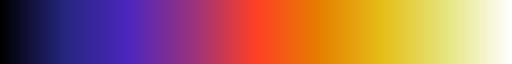

In [4]:
cmap_mode

In [13]:
# Choose scenarios
scenario_ref = 'base'
scenarios = [scenario_ref] + ['car_free']

In [42]:
input_path = '../input/'
output_path = '../outputs/scenario_validation/'
model_path = '../model/'
segments = ['car', 'no_car', 'pt_abo_car', 'pt_abo_no_car']

In [16]:
# Load model zones
ref = stepmodel.read_json(model_path + 'zones')
ref.zones = gpd.GeoDataFrame(ref.zones, crs=ref.epsg)

In [17]:
# Load simulation results
results = {scenario: stepmodel.read_zippedpickles(model_path+scenario+'/four_steps') for scenario in scenarios}

volumes: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.40s/it]


In [38]:
distances = results[scenario_ref].car_los.drop_duplicates(subset=['origin', 'destination', 'length'])\
    .set_index(['origin', 'destination'])[['length']] / 1000

# Volumes

Number of trips

In [19]:
# Inner- and inter-zonal volumes by segment
seg_df = pd.DataFrame()
for scenario in scenarios:
    vol = results[scenario].volumes
    seg_df[scenario+'_inner'] = vol.loc[vol['origin']==vol['destination'], segments].sum()
    seg_df[scenario+'_inter'] = vol.loc[vol['origin']!=vol['destination'], segments].sum()

In [24]:
# total trips
for scenario in scenarios:
    print("{}: {} mn.".format(scenario, round(seg_df[
        [scenario+suffix for suffix in ['_inter', '_inner']]].sum().sum() / 1e6, 1)))

base: 12.9 mn.
car_free: 12.9 mn.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


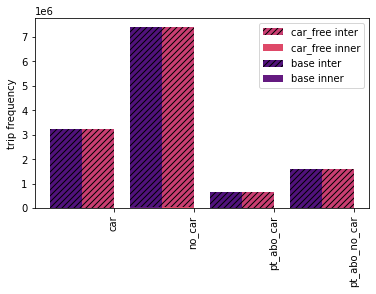

In [45]:
# Compare inner- and inter-zonal volumes by segment
# Stacked bar plot: inner+inter by scenario by segment
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3.5))
segs = segments
cmap = get_cmap('magma') # or cividis
colors_inner = {scenario: cmap(i) for scenario, i in zip(scenarios, [j/10 for j in range(3, len(scenarios)*3+1, 3)])}
colors_inter = {scenario: cmap(i) for scenario, i in zip(scenarios, [j/10-0.05 for j in range(3, len(scenarios)*3+1, 3)])}
ind = np.arange(len(segments))
width = 1/len(scenarios) - 0.1
width_filled = 0
for scenario in scenarios:
    ax.bar(ind+width_filled-width*1.5, seg_df.loc[segs, scenario+'_inner'].values,
           bottom=0, width=width,
           label=scenario+' inner',
           color=[colors_inner[scenario] for _ in segments])
    ax.bar(ind+width_filled-width*1.5, seg_df.loc[segs, scenario+'_inter'].values,
           bottom=seg_df.loc[segs, scenario+'_inner'].values,
           width=width,
           label=scenario+' inter',
           hatch='////',
           color=[colors_inter[scenario] for _ in segments])
    width_filled += width
ax.set_ylabel('trip frequency')
ax.set_xticks(ind, segs, rotation=90)
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-1], l[::-1])
plt.savefig(output_path + 'inner-inter_shares.png', dpi=dpi, bbox_inches="tight")
plt.savefig(output_path + 'inner-inter_shares.eps', bbox_inches="tight")

# Modal split

by main mode. Inter-zonal (i.e. no local transport)

In [79]:
# Define distance classes
bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 27, 30, 35, 40, 50]
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

In [80]:
ods = {}
for s in scenarios:
    ods[s] = pd.concat([results[s].car_los, results[s].pt_los]).reset_index()[
        ['origin', 'destination', 'length', 'volume', 'route_type']]
    ods[s]['bins'] = pd.cut(ods[s]['length']/1000, bins=bins, labels=labels)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


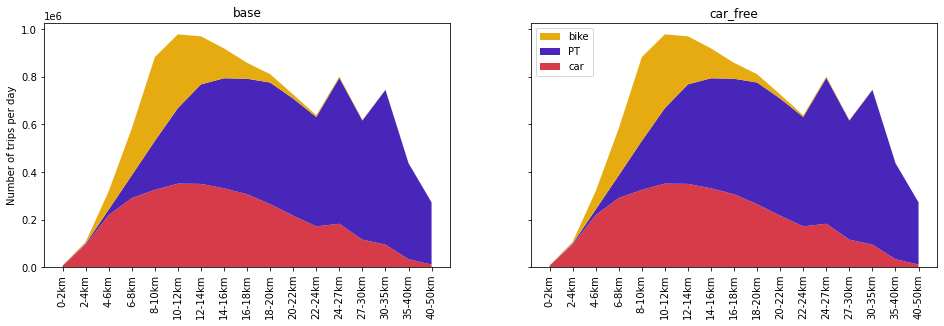

In [81]:
# Area plot with distance distribution - total
fig, ax = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(16,4.5),
                       sharex='col', sharey='row')
ind = np.arange(len(labels))
i = 0
for scenario in scenarios:
    od = ods[scenario].groupby(['bins', 'route_type']).sum().unstack('route_type')['volume']
    modes = [m for m in colormap.keys() if m in od.columns]
    od = od[modes]
    ax[i].stackplot(ind, od.T.values,
                    labels=modes,
                    colors=[colormap[m] for m in modes])#, alpha=.9)
    ax[i].set_title(scenario)
    ax[i].set_xticks(ind, labels, rotation=90)
    i += 1
    
ax[0].set_ylabel('Number of trips per day')
h, l = ax[0].get_legend_handles_labels()
h = [h[l.index(m)] for m in colormap.keys() if m in l][::-1]
l = [m for m in colormap.keys() if m in l][::-1]
ax[-1].legend(h, l, loc='upper left')
plt.savefig(output_path + 'modal_split_distance_total.png',
            dpi=dpi, bbox_inches="tight")
plt.savefig(output_path + 'modal_split_distance_total.eps',
            bbox_inches="tight")

# Passenger kilometre

pkm = #trips * distance

Take network loads (not main mode)